In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../dogs_vs_cats"))

Using TensorFlow backend.


['.ipynb_checkpoints', 'cats_vs_dogs.ipynb', 'sampleSubmission.csv', 'test1', 'train', 'Untitled.ipynb']


In [2]:
## Define Constants
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_HEIGHT]
IMAGE_CHANNELS = 3

In [3]:
## prepare training data
filenames = os.listdir("../dogs_vs_cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

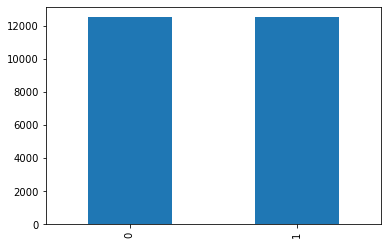

In [6]:
df['category'].value_counts().plot.bar()

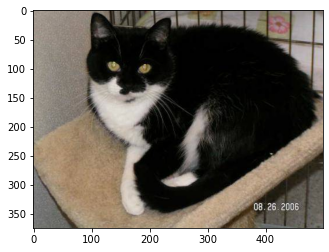

In [7]:
sample = random.choice(filenames)
image = load_img('../dogs_vs_cats/train/train/' + sample)
plt.imshow(image)

# Build Model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, 
                                                IMAGE_HEIGHT, IMAGE_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
             metrics=['binary_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
#train_df = train_df.reset_index(drop=True)
train_df

,filename,category
23311,dog.8479.jpg,dog
23623,dog.876.jpg,dog
1020,cat.10915.jpg,cat
12645,dog.10127.jpg,dog
1533,cat.11377.jpg,cat
...,...,...
21575,dog.6916.jpg,dog
5390,cat.36.jpg,cat
860,cat.10771.jpg,cat
15795,dog.1713.jpg,dog


In [15]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [16]:
train_df

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat
...,...,...
19995,dog.6916.jpg,dog
19996,cat.36.jpg,cat
19997,cat.10771.jpg,cat
19998,dog.1713.jpg,dog


<AxesSubplot:>

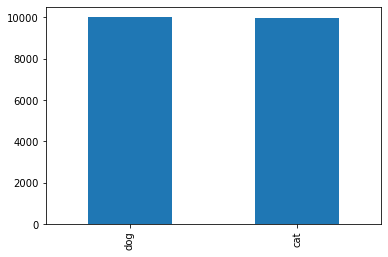

In [17]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

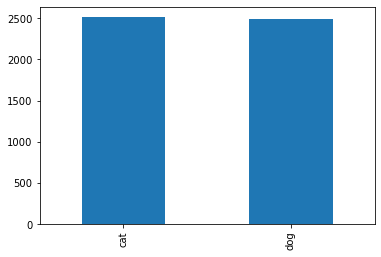

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale = 1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "../dogs_vs_cats/train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size=IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size= batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
validate_df,
"../dogs_vs_cats/train/train/",
x_col='filename',
y_col = 'category',
target_size=IMAGE_SIZE,
class_mode='categorical',
batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
## example
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
example_df,
"../dogs_vs_cats/train/train/",
x_col='filename',
y_col='category',
target_size=IMAGE_SIZE,
class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


In [23]:
example_generator

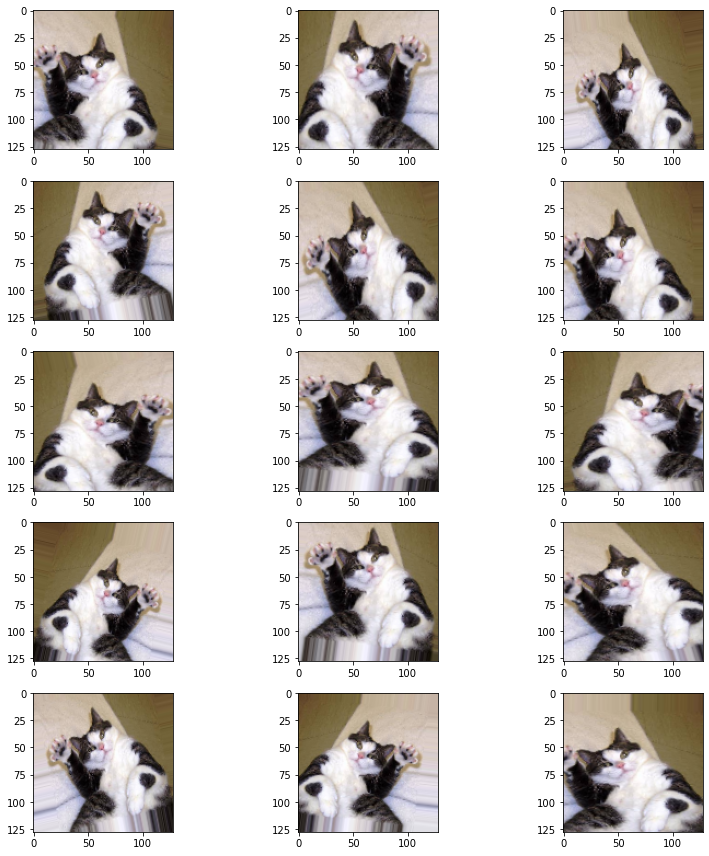

In [24]:
plt.figure(figsize=(12,12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
epochs=3 if FAST_RUN else 100
history = model.fit_generator(
train_generator,
epochs=epochs,
validation_data=validation_generator,
validation_steps=total_validate//batch_size,
steps_per_epoch=total_train//batch_size,
callbacks=callbacks)

Epoch 1/100
1333/1333 [==============================] - 144s 108ms/step - loss: 0.7631 - binary_accuracy: 0.6273 - val_loss: 0.2701 - val_binary_accuracy: 0.6735
Epoch 2/100
   3/1333 [..............................] - ETA: 1:20 - loss: 0.6534 - binary_accuracy: 0.6444

C:\Users\markn\miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_binary_accuracy,loss,binary_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 84s 63ms/step - loss: 0.5605 - binary_accuracy: 0.7188 - val_loss: 0.6407 - val_binary_accuracy: 0.6704
Epoch 3/100
1333/1333 [==============================] - 83s 63ms/step - loss: 0.5107 - binary_accuracy: 0.7551 - val_loss: 0.8687 - val_binary_accuracy: 0.7394
Epoch 4/100
1333/1333 [==============================] - 84s 63ms/step - loss: 0.4724 - binary_accuracy: 0.7797 - val_loss: 0.3977 - val_binary_accuracy: 0.8156
Epoch 5/100
1333/1333 [==============================] - 83s 62ms/step - loss: 0.4470 - binary_accuracy: 0.7968 - val_loss: 0.6421 - val_binary_accuracy: 0.7803
Epoch 6/100
1333/1333 [==============================] - 84s 63ms/step - loss: 0.4255 - binary_accuracy: 0.8084 - val_loss: 0.4180 - val_binary_accuracy: 0.8205
Epoch 7/100
1333/1333 [==============================] - 85s 64ms/step - loss: 0.4061 - binary_accuracy: 0.8212 - val_loss: 0.5870 - val_binary_accuracy: 0.7701
Epoch 8/100
1333/1333 [=======================

In [26]:
model.save_weights("model.h5")

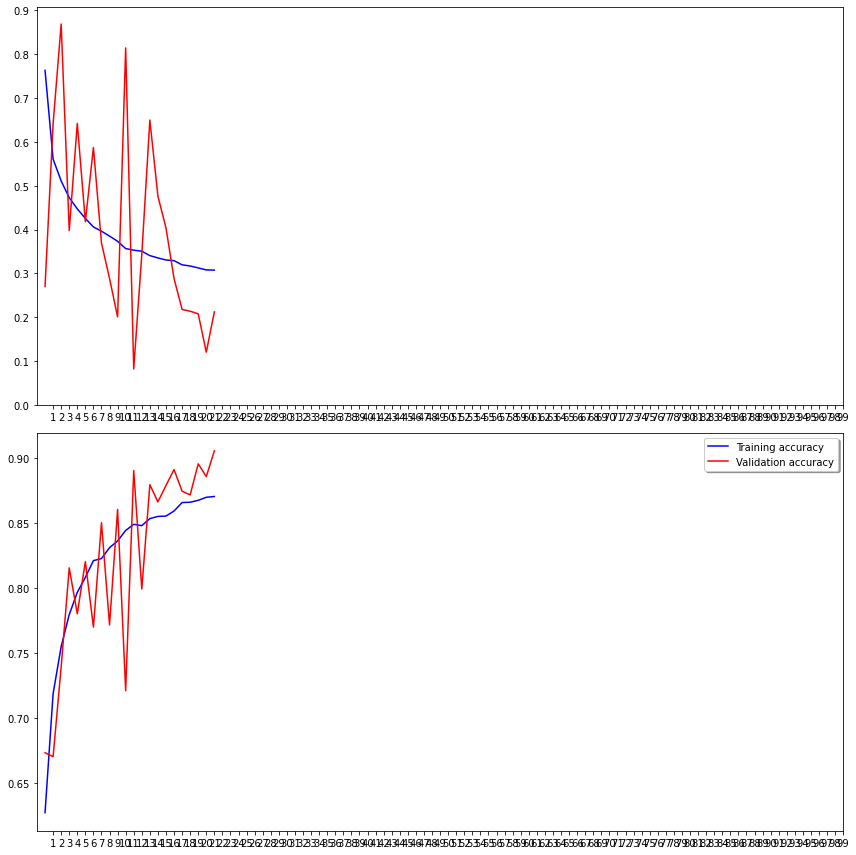

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['binary_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_binary_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [30]:
test_filenames = os.listdir('../dogs_vs_cats/test1/test1')
test_df = pd.DataFrame({
    'filename' : test_filenames
})
nb_samples = test_df.shape[0]

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
test_df,
"../dogs_vs_cats/test1/test1",
x_col='filename',
y_col=None,
class_mode=None,
target_size=IMAGE_SIZE,
batch_size=batch_size,
shuffle=False)

Found 12500 validated image filenames.


In [32]:
predict= model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [33]:
test_df['category'] = np.argmax(predict, axis=-1)

In [35]:
test_df

,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,1
3,1000.jpg,1
4,10000.jpg,1
...,...,...
12495,9995.jpg,0
12496,9996.jpg,1
12497,9997.jpg,1
12498,9998.jpg,0


In [36]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [37]:
test_df['category'] = test_df['category'].replace({'dog':1, 'cat':0})

<AxesSubplot:>

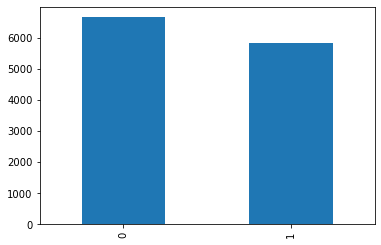

In [38]:
test_df['category'].value_counts().plot.bar()

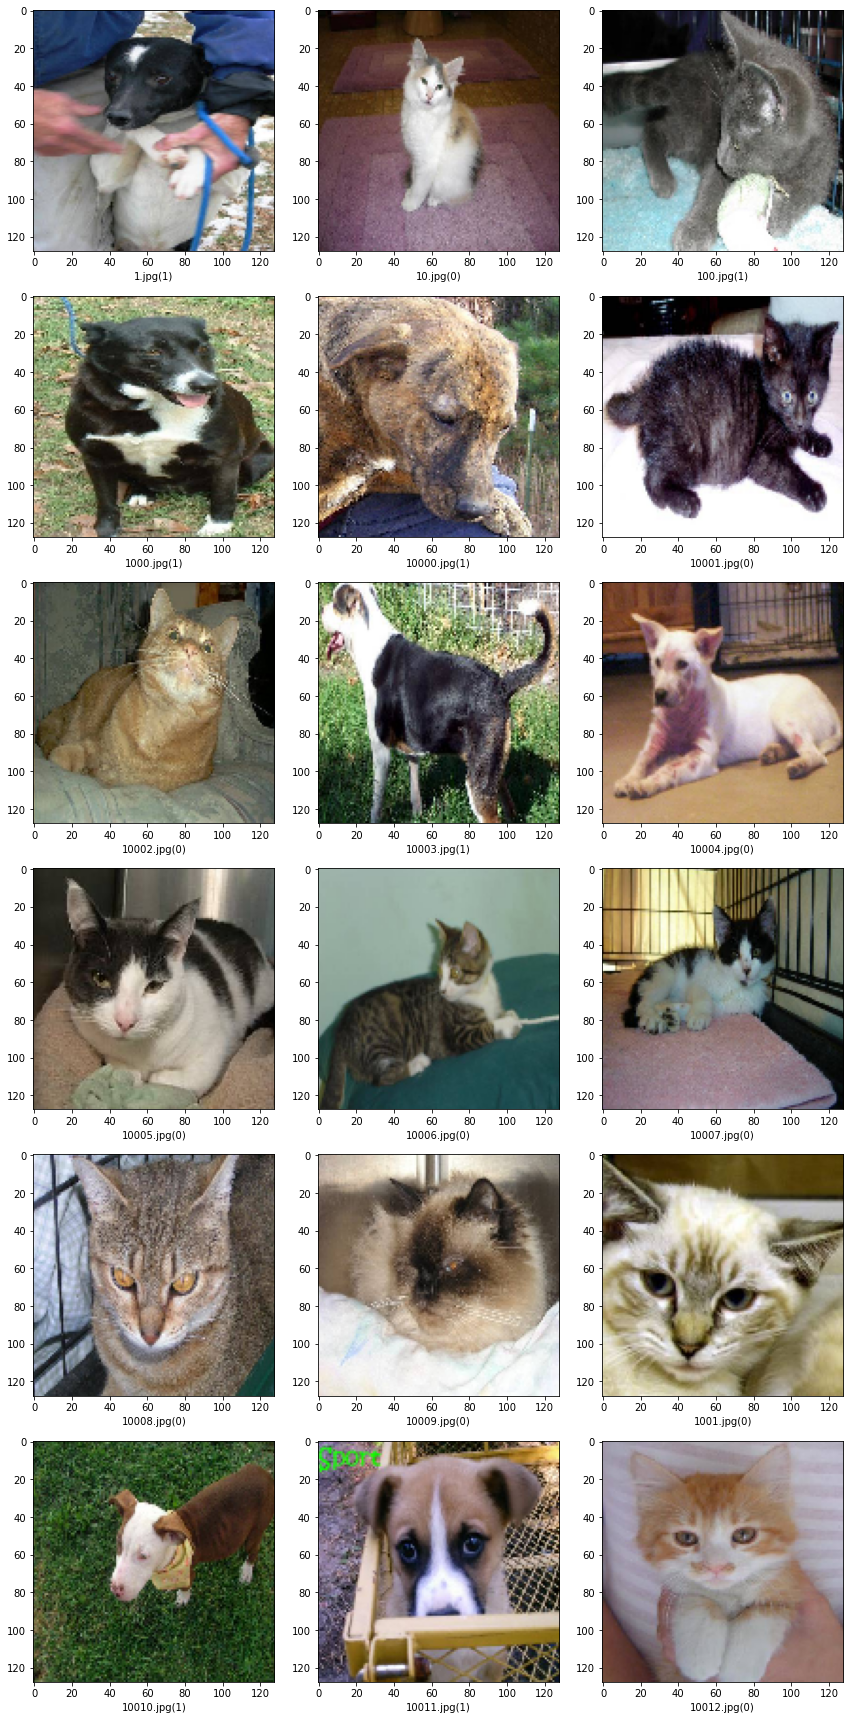

In [40]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
    filename=row['filename']
    category=row['category']
    img = load_img("../dogs_vs_cats/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [41]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)